In [1]:
import time
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import tushare as ts
ts.set_token('993df56f2f58d7cf01eb581421e762de4c45172b9979ae950bc1333a')
pro = ts.pro_api()

import mpl_finance as mpf
# import matplotlib.finance as mpf
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.pylab import date2num
import matplotlib as mpl
import seaborn as sns
sns.set()
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.sans-serif'] = 'SimHei'

D:\Users\admin\Anaconda3\envs\py37-stock\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [2]:
LOCAL = not True

In [3]:
stock_code = "000001.SZ"
start_date = "20190202"
end_date = "20200310"

if LOCAL:
    pool_df = pd.read_csv("./data/stock_basic_info.csv")
else:
    pool_df = pro.stock_basic()

if LOCAL:
    for file_dir , _ , files in os.walk("./data/daily/"):
        for i,file_name in enumerate(files):
            if file_name[:9] == stock_code:
                daily_df = pd.read_csv(file_dir+file_name)
                daily_df["trade_date"] = daily_df["trade_date"].astype("str")
                break
else:
    daily_df = pro.daily(ts_code = stock_code,start_date = start_date, end_date = end_date )
    
daily_df["trade_date2"] = daily_df["trade_date"].copy()
daily_df["trade_date"] = pd.to_datetime(daily_df["trade_date"]).map(date2num)
daily_df.sort_values(by="trade_date2", ascending=True,inplace=True)
daily_df["dates"] = np.arange(0,len(daily_df))
print(len(daily_df))
daily_df.head()

264


,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,trade_date2,dates
263,000001.SZ,737101.0,11.08,11.21,10.97,11.21,11.20,0.01,0.0893,801936.63,889951.528,20190211,0
262,000001.SZ,737102.0,11.20,11.31,11.03,11.19,11.21,-0.02,-0.1784,959936.90,1071873.084,20190212,1
261,000001.SZ,737103.0,11.19,11.41,11.12,11.38,11.19,0.19,1.6979,1137365.74,1280182.096,20190213,2
260,000001.SZ,737104.0,11.30,11.33,11.19,11.25,11.38,-0.13,-1.1424,869185.19,977818.097,20190214,3
259,000001.SZ,737105.0,11.23,11.23,10.90,10.95,11.25,-0.30,-2.6667,1100127.46,1213914.428,20190215,4


In [4]:
def get_macd(data,short=None,long=None,mid=None):
    if not short:
        short=12
    if not long:
        long=26
    if not mid:
        mid=9
    #计算短期的ema，使用pandas的ewm得到指数加权的方法，mean方法指定数据用于平均
    data['sema']=pd.Series(data['close']).ewm(span=short).mean()
    #计算长期的ema，方式同上
    data['lema']=pd.Series(data['close']).ewm(span=long).mean()
    #填充为na的数据
    data.fillna(0,inplace=True)
    #计算dif，加入新列data_dif
    data['dif']=data['sema']-data['lema']
    #计算dea
    data['dea']=pd.Series(data['dif']).ewm(span=mid).mean()
    #计算macd
    data['macd']=2*(data['dif']-data['dea'])
    # 计算 signal
    data["macd_signal"] = data["dif"].values > data['dea'].values
    data["macd_signal"] = data["macd_signal"].astype(int)
    data["macd_signal"] = data["macd_signal"].diff()
    return data

In [5]:
daily_df = get_macd(daily_df)
print(len(daily_df))
daily_df.head()

264


,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,trade_date2,dates,sema,lema,dif,dea,macd,macd_signal
263,000001.SZ,737101.0,11.08,11.21,10.97,11.21,11.20,0.01,0.0893,801936.63,889951.528,20190211,0,11.210000,11.210000,0.000000,0.000000,0.000000,NaN
262,000001.SZ,737102.0,11.20,11.31,11.03,11.19,11.21,-0.02,-0.1784,959936.90,1071873.084,20190212,1,11.199167,11.199615,-0.000449,-0.000249,-0.000399,0.0
261,000001.SZ,737103.0,11.19,11.41,11.12,11.38,11.19,0.19,1.6979,1137365.74,1280182.096,20190213,2,11.269746,11.264426,0.005320,0.002033,0.006574,1.0
260,000001.SZ,737104.0,11.30,11.33,11.19,11.25,11.38,-0.13,-1.1424,869185.19,977818.097,20190214,3,11.263513,11.260393,0.003120,0.002401,0.001437,0.0
259,000001.SZ,737105.0,11.23,11.23,10.90,10.95,11.25,-0.30,-2.6667,1100127.46,1213914.428,20190215,4,11.178333,11.188412,-0.010079,-0.001311,-0.017535,-1.0


<BarContainer object of 125 artists>

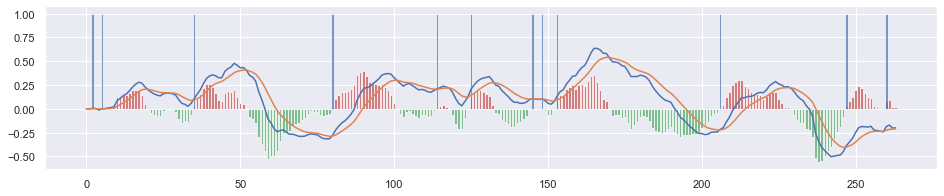

In [10]:

# plt.plot(daily_df.macd.values)
fig,ax2 = plt.subplots(figsize=(16,3))
plt.plot(daily_df.dif.values)
plt.plot(daily_df.dea.values)
ax2.bar(daily_df.query('macd >= 0')['dates'], daily_df.query('macd >= 0')['macd'], color='r', alpha=0.7)
ax2.bar(daily_df.query('macd < 0')['dates'], daily_df.query('macd < 0')['macd'], color='g', alpha=0.7)
ax2.bar(daily_df.query('macd > 0')['dates'], daily_df.query('macd > 0')['macd_signal'], color='b', alpha=0.7)

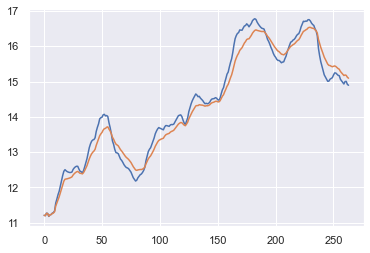

In [7]:
plt.plot(daily_df.sema.values)
plt.plot(daily_df.lema.values)